In [3]:
%matplotlib inline

In [4]:
#@title
import jax
import numpy as np

import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

try:
  import flax
except ModuleNotFoundError:
  !pip install --quiet flax==0.6.4
  import flax

try:
  import optax
except ModuleNotFoundError:
  !pip install --quiet optax
  import optax

from flax import linen as nn
from flax.training import train_state

from tqdm import trange
from functools import partial
from matplotlib import pyplot as plt

# Diffusion models

## Intro
We define the forward time SDE
$$dx_t = dtf_t(x_t) + g_tdW_t\,,$$
which defines a map from the data distribution to the normal density.

After training, we can simulate the reverse process (generate data) via the following SDE
$$dx_\tau = d\tau(-f_{1-\tau}(x_\tau) + (\frac{g_{1-\tau}^2}{2}+\xi_\tau)\nabla\log q_{1-\tau}(x_\tau)) + \sqrt{2\xi_\tau}d\bar{W}_\tau\,,$$
which becomes an ODE for $\xi_\tau \equiv 0$.

Let's define the noising SDE as the OU process, i.e. for every object in our data distribution $\mu^i \sim p_{\text{data}}(\mu)$, the noising process is
$$q_t^i(x) = \mathcal{N}(x|\alpha_t\mu^i,\sigma_t^2)\,.$$
The important part about defining this process is that we know the vector field satisfying the corresponding continuity equation
$$v_t^i(x) = (x-\alpha_t\mu^i)\frac{\partial}{\partial t}\log\sigma_t + \frac{\partial\alpha_t}{\partial t}\mu^i\,.$$
For the entire dataset we can write down the following marginal density
$$q_t(x) = \int \mathcal{N}(x|\alpha_t\mu,\sigma_t^2)p_{\text{data}}(\mu)d\mu\,,$$
and we can write down the loss for the vector field as
$$\text{Loss} = \frac{1}{N}\sum_{i=1}^N\int dt\;\int dx\;\Vert v_t(x;\theta) - v_t^i(x)\Vert^2\,,$$
where $\theta$ are the parameters of our model.

In terms of the SDE, we have
$$f_t(x) = x\frac{\partial}{\partial t}\log\alpha_t\,,\;\;\; g_t = \sqrt{2\sigma_t^2\frac{\partial}{\partial t}\log \frac{\sigma_t}{\alpha_t}}\,.$$

## Data Generation

$p_{\text{data}}(\mu)$ is just a mixture of four Gaussians. Then we define the noising process
$$q_t^i(x) = \mathcal{N}(x|\alpha_t\mu^i,\sigma_t^2)\,.$$
See code for $\alpha_t, \sigma_t$.
The plots represent samples from the following marginals for different times $t$
$$q_t(x) = \int \mathcal{N}(x|\alpha_t\mu,\sigma_t^2)p_{\text{data}}(\mu)d\mu\,.$$

In [5]:
from typing import NamedTuple, Any

def sample_data(key, bs):
  keys = random.split(key, 3)
  x_1 = random.randint(keys[0], minval=0, maxval=2, shape=(bs, 2))
  x_1 = 3*(x_1.astype(jnp.float32)-0.5)
  x_1 += 4e-1*random.normal(keys[1], shape=(bs,2))
  return x_1

t_0, t_1 = 0.0, 1.0
beta_0 = 0.1
beta_1 = 20.0
log_alpha = lambda t: -0.5*t*beta_0-0.25*t**2*(beta_1-beta_0)
# log_sigma = lambda t: jnp.log(jnp.sqrt(-jnp.expm1(-t*beta_0-0.5*t**2*(beta_1-beta_0))))
log_sigma = lambda t: jnp.log(t)
dlog_alphadt = jax.grad(lambda t: log_alpha(t).sum())
dlog_sigmadt = jax.grad(lambda t: log_sigma(t).sum())
# gamma_t = s_t d/dt log(s_t/alpha_t)
# gamma = lambda t: jnp.exp(log_sigma(t))*(dlog_sigmadt(t) - dlog_alphadt(t))
gamma = lambda t: (1 + 0.5*t*beta_0 + 0.5*t**2*(beta_1-beta_0))

def q_t(key, data, t):
  eps = random.normal(key, shape=data.shape)
  x_t = jnp.exp(log_alpha(t))*data + jnp.exp(log_sigma(t))*eps
  return eps, x_t

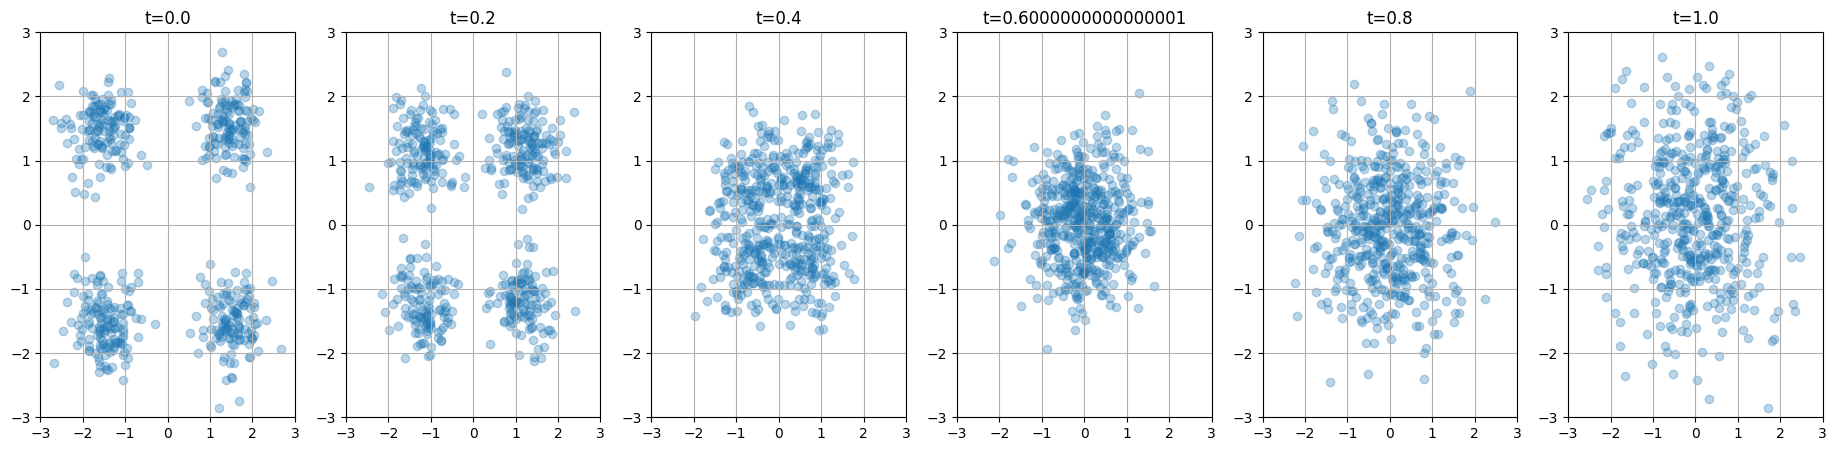

In [6]:
seed = 0
np.random.seed(seed)
key = random.PRNGKey(seed)
bs = 512
t_axis = np.linspace(0.0, 1.0, 6)

plt.figure(figsize=(23,5))
for i in range(len(t_axis)):
  plt.subplot(1,len(t_axis),i+1)
  key, *ikey = random.split(key, 3)
  _, x_t = q_t(ikey[1], sample_data(ikey[0], bs), t_axis[i])
  plt.scatter(x_t[:,0], x_t[:,1], alpha=0.3)
  plt.title(f't={t_axis[i]}')
  plt.xlim(-3,3)
  plt.ylim(-3,3)
  plt.grid()

## Define the Model

For the model of the vector field $v_t(x;\theta)$, we take an MLP.

In [7]:
class MLP(nn.Module):
  num_hid : int
  num_out : int

  @nn.compact
  def __call__(self, t, x):
    h = jnp.hstack([t,x])
    h = nn.Dense(features=self.num_hid)(h)
    h = nn.relu(h)
    h = nn.Dense(features=self.num_hid)(h)
    h = nn.swish(h)
    h = nn.Dense(features=self.num_hid)(h)
    h = nn.swish(h)
    h = nn.Dense(features=self.num_out)(h)
    return h

In [8]:
model = MLP(num_hid=512, num_out=x_t.shape[1])
print(model)

key, init_key = random.split(key)
optimizer = optax.adam(learning_rate=2e-4)
state = train_state.TrainState.create(apply_fn=model.apply,
                                      params=model.init(init_key, np.ones([bs,1]), x_t),
                                      tx=optimizer)

MLP(
    # attributes
    num_hid = 512
    num_out = 2
)


## Loss Function

In general, the loss looks like this
$$\text{Loss} = \frac{1}{N}\sum_{i=1}^N\int dt\;\int dx\;\Vert v_t(x;\theta) - v_t^i(x)\Vert^2\,.$$
However, we rewrite it a bit in terms of the score and parametrize the following quantity
$$\text{MLP}(t,x;\theta) = \sigma_t\nabla_x\log q_t(x)\,.$$

In [9]:
def sm_loss(state, key, params, bs):
  keys = random.split(key, )
  sdlogqdx = lambda _t, _x: state.apply_fn(params, _t, _x)
  data = sample_data(keys[0], bs)
  t = random.uniform(keys[1], [bs,1])
  eps, x_t = q_t(keys[2], data, t)
  loss = ((eps + sdlogqdx(t, x_t))**2).sum(1)
  print(loss.shape, 'final.shape', flush=True)
  return loss.mean()

@partial(jax.jit, static_argnums=1)
def train_step(state, bs, key):
  grad_fn = jax.value_and_grad(sm_loss, argnums=2)
  loss, grads = grad_fn(state, key, state.params, bs)
  state = state.apply_gradients(grads=grads)
  return state, loss

key, loc_key = random.split(key)
state, loss = train_step(state, bs, loc_key)

(512,) final.shape


## Train Loop

In [10]:
num_iterations = 20_000

loss_plot = np.zeros(num_iterations)
key, loop_key = random.split(key)
for iter in trange(num_iterations):
  state, loss = train_step(state, bs, random.fold_in(loop_key, iter))
  loss_plot[iter] = loss

100%|██████████| 20000/20000 [05:24<00:00, 61.54it/s]


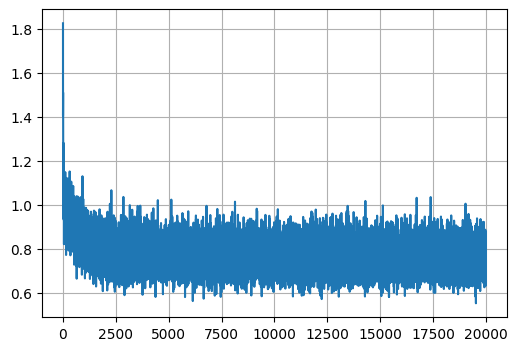

In [11]:
plt.figure(figsize=(6,4))
plt.plot(loss_plot)
plt.grid()

## Evaluation of the Trained Model

$$dx_\tau = d\tau(-f_{1-\tau}(x_\tau) + (\frac{g_{1-\tau}^2}{2}+\xi_\tau)\nabla\log q_{1-\tau}(x_\tau)) + \sqrt{2\xi_\tau}d\bar{W}_\tau\,,$$
$$f_t(x) = x\frac{\partial}{\partial t}\log\alpha_t\,,\;\;\; g_t = \sqrt{2\sigma_t^2\frac{\partial}{\partial t}\log \frac{\sigma_t}{\alpha_t}}\,\;\;\; \gamma_t = \sigma_t\frac{\partial}{\partial t}\log \frac{\sigma_t}{\alpha_t}.$$

In [12]:
# v_t(x) = -dlog(alpha)/dt x + s^2_t d/dt log(s_t/alpha_t) dlog q_t(x)/dx
@jax.jit
def vector_field(t,x,xi=0.0):
  sdlogqdx = lambda _t, _x: state.apply_fn(state.params, _t, _x)
  dxdt = -dlog_alphadt(t)*x + gamma(t)*sdlogqdx(t, x) + xi*gamma(t)*sdlogqdx(t, x)
  return dxdt

In [13]:
dt = 1e-2
xi = 1.0
t = 1.0
n = int(t/dt)
t = t*jnp.ones((bs,1))
key, ikey = random.split(key, num=2)
x_gen = jnp.zeros((bs,n+1,x_t.shape[1]))
x_gen = x_gen.at[:,0,:].set(random.normal(ikey, shape=(bs, x_t.shape[1])))
for i in trange(n):
  key, ikey = random.split(key, num=2)
  dx = dt*vector_field(t, x_gen[:,i,:], xi) + jnp.sqrt(2*xi*gamma(t)*jnp.exp(log_sigma(t))*dt)*random.normal(ikey, shape=(bs,2))
  x_gen = x_gen.at[:,i+1,:].set(x_gen[:,i,:] + dx)
  t += -dt

100%|██████████| 100/100 [00:00<00:00, 119.95it/s]


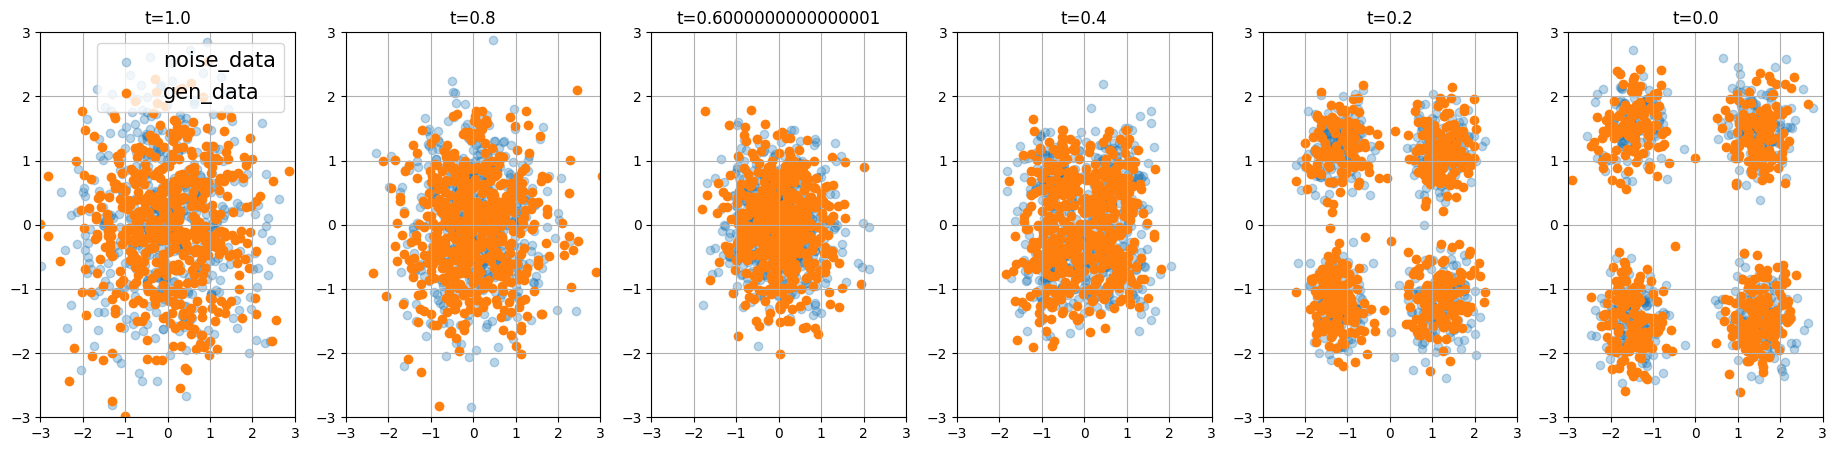

In [14]:
plt.figure(figsize=(23,5))
for i in range(len(t_axis)):
  plt.subplot(1,len(t_axis),i+1)
  key, *ikey = random.split(key, 3)
  t = t_axis[len(t_axis)-1-i]
  _, x_t = q_t(ikey[1], sample_data(ikey[0], bs), t)
  plt.scatter(x_t[:,0], x_t[:,1], label='noise_data', alpha=0.3)
  plt.scatter(x_gen[:,int(n*(t_axis[i])),0], x_gen[:,int(n*(t_axis[i])),1], label='gen_data')
  plt.title(f't={t}')
  plt.xlim(-3,3)
  plt.ylim(-3,3)
  plt.grid()
  if i == 0:
    plt.legend(fontsize=15)

## Annealing

Let's use the following estimator
$$dx_\tau = d\tau(-f_{1-\tau}(x_\tau) + \beta g_{1-\tau}^2\nabla\log q_{1-\tau}(x_\tau)) + g_{1-\tau}d\bar{W}_\tau\,,$$
$$dw_\tau = (\beta-1)\langle \nabla, f_{1-\tau}\rangle + \frac{1}{2}g_{1-\tau}^2(\beta-1)\beta\Vert\nabla \log q_{1-\tau}\Vert^2$$
where $\beta$ is the inverse temperature

# *** RESAMPLING CODE **

In [15]:
# def sample_uniform(bs, start, u0=0.0, u1=1.0):
#     u = (start + jnp.sqrt(2)*jnp.arange(bs*jax.device_count()+1)) % 1
#     start=u[-1]
#     u = (u1-u0)*u[jax.process_index()*bs:(jax.process_index()+1)*bs] + u0
#     return u, start

from scipy.stats import qmc
sampler = qmc.Sobol(d=1, scramble=False)

def sample_cat(bs, next_u, logits):
    # u, next_u = sample_uniform(bs, next_u)
    u = sampler.random(bs).squeeze()
    bins = jnp.cumsum(nn.softmax(logits))
    ids = jnp.digitize(u, bins)
    return ids, next_u

@partial(jax.jit, static_argnums=0)
def sample_cat_sys(bs, key, logits):
    u = jax.random.uniform(key, shape=(1,))
    u = (u + 1/bs*jnp.arange(bs)) % 1
    bins = jnp.cumsum(nn.softmax(logits))
    ids = jnp.digitize(u, bins)
    return ids, None


@partial(jax.jit, static_argnums=[0,5])
def sample_birth_death_clocks(bs, key, accum_birth, accum_death, thresh_times, reset_transition_per_index=True):
    
    key, *keys = random.split(key, num=3)

    death_mask = (accum_death >= thresh_times)
    
    ids = jnp.arange(bs)
    
    ''' sample candidate replacement indices according to *accumulated* birth weights (justified?  works well tho)''' 
    if reset_transition_per_index:
        transition_probs = accum_birth/jnp.sum(accum_birth, axis=-1, keepdims=True)
        subkeys = jax.random.split(keys[0], transition_probs.shape[0])
        replace_ids = jax.vmap(lambda _key, p: jax.random.choice(_key, ids, p=p))(subkeys, transition_probs)
    else:
        transition_probs = accum_birth/jnp.sum(accum_birth)
        replace_ids = jax.random.choice(keys[0], ids,  shape=(bs,), p = transition_probs , replace=True)

    ''' replace those entries chosen for killing ''' 
    ids = jnp.where(death_mask, replace_ids, ids)
        
    ''' sample new jump thresholds'''
    new_thresh_times = random.exponential(keys[1], shape=(bs,)) 
        
    thresh_times = jnp.where(death_mask, new_thresh_times, thresh_times)

    ''' reset birth and death weights in killed indices '''
    if reset_transition_per_index:
        accum_birth = jnp.where(death_mask.reshape(-1,1), jnp.zeros_like(accum_birth), accum_birth)
    else:
        accum_birth = jnp.where(death_mask, jnp.zeros_like(accum_birth), accum_birth)

    accum_death = jnp.where(death_mask, jnp.zeros_like(accum_death), accum_death)
    
    metrics = (jnp.sum(death_mask),)
    return ids, accum_birth, accum_death, thresh_times, metrics

In [33]:
# @jax.jit
# def sdlogqdx_fn(t,x):
#   return state.apply_fn(state.params, t, x)

# ''' HYPERPARAMS ''' 
# resample = 'birth_death_clock'
# reset_transition_per_index = True

# scale_noise= True


# inv_temp = 10
# next_u = 0.5
# dt = 1e-3
# t = 1.0
# n = int(t/dt)
# t = t*jnp.ones((bs,1))
# key, ikey = random.split(key, num=2)
# x_gen = jnp.zeros((bs,n+1,x_t.shape[1]))
# x_gen = x_gen.at[:,0,:].set(random.normal(ikey, shape=(bs, x_t.shape[1]))/jnp.sqrt(inv_temp))
# w_gen = jnp.zeros((bs,n+1,1))


# ''' NEW SETUP '''
# if resample == 'birth_death_clock':
#     if reset_transition_per_index:
#       accum_birth = jnp.zeros((w_gen.shape[0], bs))
#     else:
#       accum_birth = jnp.zeros(w_gen.shape[0])

#     accum_death = jnp.zeros(w_gen.shape[0])
#     key, ikey = random.split(key, num=2)
#     clock_thresholds = random.exponential(ikey, shape=(bs,))
    
    
# for i in trange(n):
#   key, *ikey = random.split(key, num=3)
#   sdlogqdx = sdlogqdx_fn(t, x_gen[:,i,:])
  
#   if not scale_noise:
#     dx = dt*(-dlog_alphadt(t)*x_gen[:,i,:] + 2*inv_temp*gamma(t)*sdlogqdx) + jnp.sqrt(2*gamma(t)*jnp.exp(log_sigma(t))*dt)*random.normal(ikey[0], shape=(bs,2))
#   else:
#     dx = dt*(-dlog_alphadt(t)*x_gen[:,i,:] + (gamma(t)+inv_temp*gamma(t))*sdlogqdx) + jnp.sqrt(2*gamma(t)/inv_temp*jnp.exp(log_sigma(t))*dt)*random.normal(ikey[0], shape=(bs,2))
#   x_gen = x_gen.at[:,i+1,:].set(x_gen[:,i,:] + dx)
  
#   dw = dt*((inv_temp-1)*2*dlog_alphadt(t) + 0.5*(inv_temp-1)*inv_temp*((jnp.sqrt(2*gamma(t)/jnp.exp(log_sigma(t)))*sdlogqdx)**2).sum(1, keepdims=True))
#   w_gen = w_gen.at[:,i+1,:].set(w_gen[:,i,:] + dw)

  
#   if resample == 'birth_death_clock':
#     ''' note, dw is correctly scaled by dt'''
#     dw = dw[:,0] # spurious extra dim
#     avg = jnp.mean(dw, axis=0, keepdims=True)
    
#     ''' accumulate thresholded weight increments (only sizing differences)'''
#     accum_death = accum_death + jnp.where(dw-avg<0, avg-dw, jnp.zeros_like(dw))
#     if reset_transition_per_index:
#       bw_inc = jnp.where(dw-avg>0, dw-avg, jnp.zeros_like(dw))
#       accum_birth = accum_birth + bw_inc[:,None]
#     else:
#       accum_birth = accum_birth + jnp.where(dw-avg>0, dw-avg, jnp.zeros_like(dw))
      
    
#     ''' sampler resets accum_birth/death, clock_thresholds where necessary '''
#     new_ids, accum_birth, accum_death, clock_thresholds, metrics \
#       = sample_birth_death_clocks(bs, ikey[1], accum_birth, accum_death, clock_thresholds, reset_transition_per_index)
    
#     x_gen = x_gen.at[:,i+1,:].set(x_gen[new_ids,i+1,:])
    
    
#     ''' resetting the weights has no effect here '''
#     w_gen = w_gen.at[:,i+1,:].set(0)
    
#   elif resample == 'systematic':
#     # new_ids = jax.random.choice(ikey[1], bs, (bs,), p=nn.softmax(w_gen[:,i+1,0]))
#     # new_ids, next_u = sample_cat(bs, next_u, w_gen[:,i+1,0])
#     new_ids, _ = sample_cat_sys(bs, ikey[1], w_gen[:,i+1,0])
#     x_gen = x_gen.at[:,i+1,:].set(x_gen[new_ids,i+1,:])
#     w_gen = w_gen.at[:,i+1,:].set(0)
#   t += -dt


# reward-tilted target density with keyman-kac correctors
# this implements equations 29-30 from the paper for sampling from p_t^reward(x) ∝ q_t(x) * exp(beta_t * r(x))

# ===================================================================================
# beta schedule definition
# ===================================================================================
# beta_t controls the strength of reward tilting over time
# we use linear annealing
def beta_schedule(t, T_max=1.0, beta_start=0.1, beta_end=10.0):
  # increase β as we go from t=1 → 0  (small at start, large at end)
  return beta_start + (beta_end - beta_start) * (1.0 - t / T_max)

def dbeta_dt_schedule(t, T_max=1.0, beta_start=0.1, beta_end=10.0):
  # derivative of the schedule above w.r.t. "forward" time t
  return -(beta_end - beta_start) / T_max

# ===================================================================================
# reward-tilted SDE implementation
# ===================================================================================
# this implements the core SDE's from the paper (equations 29 and 30)

# @jax.jit #jit compile for speed
# def reward_tilted_sde_step(rng, x_t, w_t, t, dt, T_max, beta_start, beta_end):
#   # single step of reward-tilted SDE integration
#   """
#   args: 
#     rng: jax random key
#     x_t: current state (batch_size, state_dim)
#     w_t: current weights (batch_size, 1)
#     t: current time 
#     dt: time step
#     T_max: total time 
#     beta_start, beta_end: beta schedule parameters
#   returns:
#     rng: updated random key
#     x_next: next state
#     w_next: next weights
#   """
#   # get current beta_t and its time derivative
#   current_beta = beta_schedule(t, T_max, beta_start, beta_end) # beta_t
#   dbeta_t = dbeta_dt_schedule(t, T_max, beta_start, beta_end) 
  
#   # get current sigma_t (noise level) and sigma_t^2
#   current_sigma = jnp.exp(log_sigma(t)) # sigma_t from existing diffusion schedule
#   sigma_sq = current_sigma**2 # sigma_t^2 needed for SDE
  
#   # compute reward function and its gradient at current state
#   r_xt = vmap(reward_function)(x_t) # r(x_t) reward at current state
#   grad_r_xt = jax.vmap(grad_reward_func, in_axes=(0,))(x_t)
  
#   # get score function from trained diffusion model
#   t_batch = jnp.full((x_t.shape[0], 1), t)
#   sdlogqdx = state.apply_fn(state.params, t_batch, x_t) # score function
  
#   # get drift function from reverse SDE
#   f_xt = -dlog_alphadt(t) * x_t # base diffusion drift
  
#   # ===================================================================================
#   # equation 29: state evolution SDE
#   # ===================================================================================
#   # drift term: combines score function with reward gradient
#   drift_x = sigma_sq * (sdlogqdx + (current_beta / 2.0) * grad_r_xt) - f_xt

#   # diffusion term: random noise scaled by sigma_t
#   rng, subkey = jax.random.split(rng) # split random key for noise generation
#   dW_t = jax.random.normal(subkey, x_t.shape) * jnp.sqrt(dt) # brownian motion increment
#   dx_t = drift_x * dt + current_sigma * dW_t  # complete state update

#   # ===================================================================================
#   # equation 30: weight evolution SDE
#   # ===================================================================================
#   # term 1: time derivative of beta times reward
#   term1_w = (dbeta_t * r_xt)[:, None]

#   # term 2: negative inner product of reward gradient with base drift
#   term2_w = -jnp.sum(current_beta * grad_r_xt * f_xt, axis=1, keepdims=True)

#   # term 3: inner product of reward gradient with score function
#   term3_w = -jnp.sum(current_beta * grad_r_xt * (sigma_sq / 2.0) * sdlogqdx, axis=1, keepdims=True) 

#   # combine all terms for weight update
#   dw_t = (term1_w + term2_w + term3_w) * dt # complete weight update

#   # update states
#   x_next = x_t + dx_t # next state
#   w_next = w_t + dw_t # next weights

#   return rng, x_next, w_next
@jax.jit
def reward_tilted_sde_step(
    rng,
    x_t,                 # (B, 2)
    w_t,                 # (B, 1)  - log-weights
    t,                   # scalar in [0, T_max], we integrate t: 1 → 0
    dt,
    T_max,
    beta_hat_start,      # ~ O(0.1)
    beta_hat_end,        # ~ O(2–10) to start; tune as needed
    reward_fn,           # (2,) -> scalar
    grad_reward_fn       # (2,) -> (2,)
):
  # diffusion scale
  sigma_t = jnp.exp(log_sigma(t))              # σ(t)
  sigma2  = sigma_t * sigma_t                  # σ(t)^2
  eps     = 1e-6

  # β̂ schedule grows as t → 0
  beta_hat  = beta_hat_start + (beta_hat_end - beta_hat_start) * (1.0 - t / T_max)
  dbeta_hat = -(beta_hat_end - beta_hat_start) / T_max

  # effective β_t so that σ^2 β_t ≈ β̂ (kept O(1) at small t)
  beta_t  = beta_hat / jnp.maximum(sigma2, eps)
  # dβ/dt = d/dt (β̂ / σ^2) = (dbeta_hat * σ^2 - β̂ * d(σ^2)/dt) / σ^4
  # we approximate with: dbeta_t ≈ dbeta_hat / max(σ^2, eps)
  dbeta_t = dbeta_hat / jnp.maximum(sigma2, eps)

  # reward and gradient (batched)
  r_xt   = jax.vmap(reward_fn,        in_axes=(0,))(x_t)      # (B,)
  grad_r = jax.vmap(grad_reward_fn,   in_axes=(0,))(x_t)      # (B,2)

  # model output: σ(t) ∇ log q_t(x)  → true score via divide by σ(t)
  t_batch = jnp.full((x_t.shape[0], 1), t)
  mlp_out = state.apply_fn(state.params, t_batch, x_t)        # (B,2) = σ ∇log q
  score   = mlp_out / jnp.maximum(sigma_t, 1e-8)              # (B,2) = ∇log q

  # base reverse drift f_t(x) = - d/dt log α_t · x
  f_xt = -dlog_alphadt(t) * x_t

  # STATE SDE (Eq. 29): dx = [σ^2 (score + (β/2)∇r) - f] dt + σ dW
  drift_x = sigma2 * (score + 0.5 * beta_t * grad_r) - f_xt
  rng, sub = jax.random.split(rng)
  dW      = jax.random.normal(sub, x_t.shape) * jnp.sqrt(dt)
  # Optional: taper stochasticity near the end for tighter convergence
  noise_scale = sigma_t * (t / T_max)
  x_next  = x_t + drift_x * dt + noise_scale * dW

  # WEIGHT SDE (Eq. 30):
  # dw = (∂β/∂t) r dt - ⟨β∇r, f⟩ dt + ⟨β∇r, (σ^2/2) score⟩ dt
  term1 = dbeta_t * r_xt[:, None]
  term2 = -jnp.sum(beta_t * grad_r * f_xt, axis=1, keepdims=True)
  term3 =  jnp.sum(beta_t * grad_r * (0.5 * sigma2) * score, axis=1, keepdims=True)
  w_next = w_t + (term1 + term2 + term3) * dt

  return rng, x_next, w_next

reward function suite

In [28]:
## Data Generation

# ===================================================================================

def reward_function_center(x):
    """Reward 1: Distance to center (origin)
    Higher reward for points closer to origin (0,0)
    """
    return -jnp.sum(x**2)

def reward_function_boundary(x, boundary_radius=2.0):
    """Reward 2: Distance to circular boundary
    Higher reward for points closer to the circular boundary
    """
    distance_to_origin = jnp.sqrt(jnp.sum(x**2))
    distance_to_boundary = jnp.abs(distance_to_origin - boundary_radius)
    return -distance_to_boundary

def reward_function_quadrants(x, target_points=None):
    """Reward 3: Distance to specific points in each quadrant
    Higher reward for points closer to any of the target points
    """
    if target_points is None:
        # Default target points in each quadrant
        target_points = jnp.array([[1.5, 1.5], [-1.5, 1.5], [-1.5, -1.5], [1.5, -1.5]])
    
    # ensure x is a row vector of shape (1, 2)
    x = jnp.reshape(x, (1, -1))
    # compute distances to all target points
    distances = jnp.linalg.norm(x - target_points, axis=1)
    # Return negative of minimum distance (closer = higher reward)
    return -jnp.min(distances)

def reward_function_ring(x, inner_radius=1.0, outer_radius=2.0):
    """Reward 4: Ring-shaped reward
    Higher reward for points in the ring between inner and outer radius
    """
    distance_to_origin = jnp.sqrt(jnp.sum(x**2))
    # Reward is high when distance is between inner and outer radius
    ring_penalty = jnp.where(
        (distance_to_origin >= inner_radius) & (distance_to_origin <= outer_radius),
        0.0,  # No penalty inside ring
        jnp.minimum(
            jnp.abs(distance_to_origin - inner_radius),
            jnp.abs(distance_to_origin - outer_radius)
        )**2  # Quadratic penalty outside ring
    )
    return -ring_penalty

# Create gradient functions for all reward functions
grad_reward_center = grad(reward_function_center)
grad_reward_boundary = grad(reward_function_boundary)
grad_reward_quadrants = grad(reward_function_quadrants)
grad_reward_ring = grad(reward_function_ring)

# Vectorized versions for batch processing
vmap_grad_reward_center = vmap(grad_reward_center)
vmap_grad_reward_boundary = vmap(grad_reward_boundary)
vmap_grad_reward_quadrants = vmap(grad_reward_quadrants)
vmap_grad_reward_ring = vmap(grad_reward_ring)

sde step function

In [25]:
# ===================================================================================
# Generic Reward-Tilted SDE Step
# ===================================================================================

def reward_tilted_sde_step_generic(rng, x_t, w_t, t, dt, T_max, beta_start, beta_end, 
                                  reward_func, grad_reward_func):
    """Generic reward-tilted SDE step that works with any reward function"""
    # get current beta_t and its time derivative
    current_beta = beta_schedule(t, T_max, beta_start, beta_end) # beta_t
    dbeta_t = dbeta_dt_schedule(t, T_max, beta_start, beta_end) 
    
    # get current sigma_t (noise level) and sigma_t^2
    current_sigma = jnp.exp(log_sigma(t)) # sigma_t from existing diffusion schedule
    sigma_sq = current_sigma**2 # sigma_t^2 needed for SDE
    
    # compute reward function and its gradient at current state
    r_xt = vmap(reward_func)(x_t) # r(x_t) reward at current state
    grad_r_xt = jax.vmap(grad_reward_func, in_axes=(0,))(x_t)
    
    # get score function from trained diffusion model
    t_batch = jnp.full((x_t.shape[0], 1), t)
    sdlogqdx = state.apply_fn(state.params, t_batch, x_t) # score function
    
    # get drift function from reverse SDE
    f_xt = -dlog_alphadt(t) * x_t # base diffusion drift
    
    # ===================================================================================
    # equation 29: state evolution SDE
    # ===================================================================================
    # drift term: combines score function with reward gradient
    drift_x = sigma_sq * (sdlogqdx + (current_beta / 2.0) * grad_r_xt) - f_xt

    # diffusion term: random noise scaled by sigma_t
    rng, subkey = jax.random.split(rng) # split random key for noise generation
    dW_t = jax.random.normal(subkey, x_t.shape) * jnp.sqrt(dt) # brownian motion increment
    dx_t = drift_x * dt + current_sigma * dW_t  # complete state update

    # ===================================================================================
    # equation 30: weight evolution SDE
    # ===================================================================================
    # term 1: time derivative of beta times reward
    term1_w = (dbeta_t * r_xt)[:, None]  # ensure shape (batch_size, 1)

    # term 2: negative inner product of reward gradient with base drift
    term2_w = -jnp.sum(current_beta * grad_r_xt * f_xt, axis=1, keepdims=True)

    # term 3: inner product of reward gradient with score function
    term3_w = -jnp.sum(current_beta * grad_r_xt * (sigma_sq / 2.0) * sdlogqdx, axis=1, keepdims=True) 

    # combine all terms for weight update
    dw_t = (term1_w + term2_w + term3_w) * dt # complete weight update

    # update states
    x_next = x_t + dx_t # next state
    w_next = w_t + dw_t # next weights

    return rng, x_next, w_next

generation function

In [19]:
# ===================================================================================
# Generation Function 
# ===================================================================================

def generate_with_reward_function(key, reward_name, reward_func, grad_reward_func, 
                                 n_steps=1000, bs=512, dt=1e-3, T_max=1.0, 
                                 beta_start=0.1, beta_end=10.0, resample=True):
    """Generate samples using a specific reward function"""
    print(f"\n Generating with reward function: {reward_name}")
    
    # initialize generation arrays
    key, ikey = random.split(key, num=2) # split random key
    x_gen = jnp.zeros((bs, n_steps + 1, 2)) # state trajectory: (batch_size, time_steps, state_dim)
    w_gen = jnp.zeros((bs, n_steps + 1, 1)) # weight trajectory: (batch_size, time_steps, 1)

    # initialize with noise (starting from t=1, going to t=0)
    x_gen = x_gen.at[:, 0, :].set(random.normal(ikey, shape=(bs, 2))) # start from noise
    w_gen = w_gen.at[:, 0, :].set(0.0) # start with zero weights

    # time starts at t=1 and goes to t=0
    t = T_max

    for i in trange(n_steps, desc=f'reward-tilted generation ({reward_name})'):
        # split random key for this step
        key, *ikey = random.split(key, num=3)
        
        # perform one step of reward-tilted SDE
        key, x_next, w_next = reward_tilted_sde_step_generic(
            key, x_gen[:, i, :], w_gen[:, i, :], t, dt, T_max, beta_start, beta_end,
            reward_func, grad_reward_func
        )
        
        # update arrays using JAX's immutable update methods
        x_gen = x_gen.at[:, i+1, :].set(x_next)
        w_gen = w_gen.at[:, i+1, :].set(w_next)
        
        # Optional: resampling step
        if resample and i % 100 == 0:  # resample every 100 steps
            new_ids, _ = sample_cat_sys(bs, ikey[1], w_gen[:, i+1, 0])
            x_gen = x_gen.at[:, i+1, :].set(x_gen[new_ids, i+1, :])
            w_gen = w_gen.at[:, i+1, :].set(0.0)
        
        t -= dt
    
    return key, x_gen, w_gen  # Return updated key

visualization function

In [20]:
# ===================================================================================
# Visualization Functions
# ===================================================================================

def plot_reward_evolution(reward_name, x_gen, w_gen, n_steps=1000, bs=512):
    """Plot point distributions at specific time levels following notebook schema"""
    # Define time points to visualize (similar to original notebook)
    t_axis = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]  # Time points from t=0 to t=1
    n = n_steps
    
    plt.figure(figsize=(15, 10))
    
    for i, t_val in enumerate(t_axis):
        plt.subplot(2, 3, i+1)
        
        # Calculate the corresponding index in the trajectory
        t_idx = int(n * t_val)
        if t_idx >= x_gen.shape[1]:
            t_idx = x_gen.shape[1] - 1
        
        # Plot generated samples at this time point
        plt.scatter(x_gen[:, t_idx, 0], x_gen[:, t_idx, 1], 
                   alpha=0.6, s=20, label='generated', color='blue')
        
        # Add some reference data if available (optional)
        # You can add noise samples at this time point for comparison
        key_temp = random.PRNGKey(42)  # Fixed seed for consistent reference
        noise_samples = random.normal(key_temp, shape=(bs, 2))
        plt.scatter(noise_samples[:, 0], noise_samples[:, 1], 
                   alpha=0.3, s=10, label='noise', color='red')
        
        plt.title(f'{reward_name} - t={t_val:.1f}')
        plt.xlabel('x1')
        plt.ylabel('x2')
        plt.xlim(-3, 3)
        plt.ylim(-3, 3)
        plt.grid(True, alpha=0.3)
        
        if i == 0:
            plt.legend(fontsize=12)
    
    plt.suptitle(f'Evolution of Generated Samples: {reward_name}', fontsize=16)
    plt.tight_layout()
    plt.show()

def plot_reward_heatmap(reward_func, reward_name, x_range=(-3, 3), y_range=(-3, 3), resolution=100):
    """Plot reward function heatmap"""
    x = jnp.linspace(x_range[0], x_range[1], resolution)
    y = jnp.linspace(y_range[0], y_range[1], resolution)
    X, Y = jnp.meshgrid(x, y)
    points = jnp.stack([X.ravel(), Y.ravel()], axis=1)    
    # Compute rewards for all points
    rewards = vmap(reward_func)(points)
    reward_grid = rewards.reshape(resolution, resolution)
    
    plt.figure(figsize=(8, 6))
    plt.contourf(X, Y, reward_grid, levels=20, cmap='viridis')
    plt.colorbar(label='Reward Value')
    plt.title(f'Reward Function: {reward_name}')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.xlim(x_range)
    plt.ylim(y_range)
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_reward_comparison(reward_functions, reward_names, x_range=(-3, 3), y_range=(-3, 3), resolution=100):
    """Plot multiple reward functions in a grid"""
    n_rewards = len(reward_functions)
    cols = min(3, n_rewards)
    rows = (n_rewards + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
    if n_rewards == 1:
        axes = [axes]
    elif rows == 1:
        axes = axes.reshape(1, -1)
    
    for i, (reward_func, reward_name) in enumerate(zip(reward_functions, reward_names)):
        row, col = i // cols, i % cols
        ax = axes[row, col] if rows > 1 else axes[col]
        
        x = jnp.linspace(x_range[0], x_range[1], resolution)
        y = jnp.linspace(y_range[0], y_range[1], resolution)
        X, Y = jnp.meshgrid(x, y)
        points = jnp.stack([X.flatten(), Y.flatten()], axis=1)
        
        rewards = vmap(reward_func)(points)
        reward_grid = rewards.reshape(resolution, resolution)
        
        im = ax.contourf(X, Y, reward_grid, levels=20, cmap='viridis')
        ax.set_title(f'Reward: {reward_name}')
        ax.set_xlabel('x1')
        ax.set_ylabel('x2')
        ax.set_xlim(x_range)
        ax.set_ylim(y_range)
        ax.grid(True, alpha=0.3)
        
        # Add colorbar
        plt.colorbar(im, ax=ax, label='Reward Value')
    
    # Hide empty subplots
    for i in range(n_rewards, rows * cols):
        row, col = i // cols, i % cols
        ax = axes[row, col] if rows > 1 else axes[col]
        ax.set_visible(False)
    
    plt.tight_layout()
    plt.show()

main

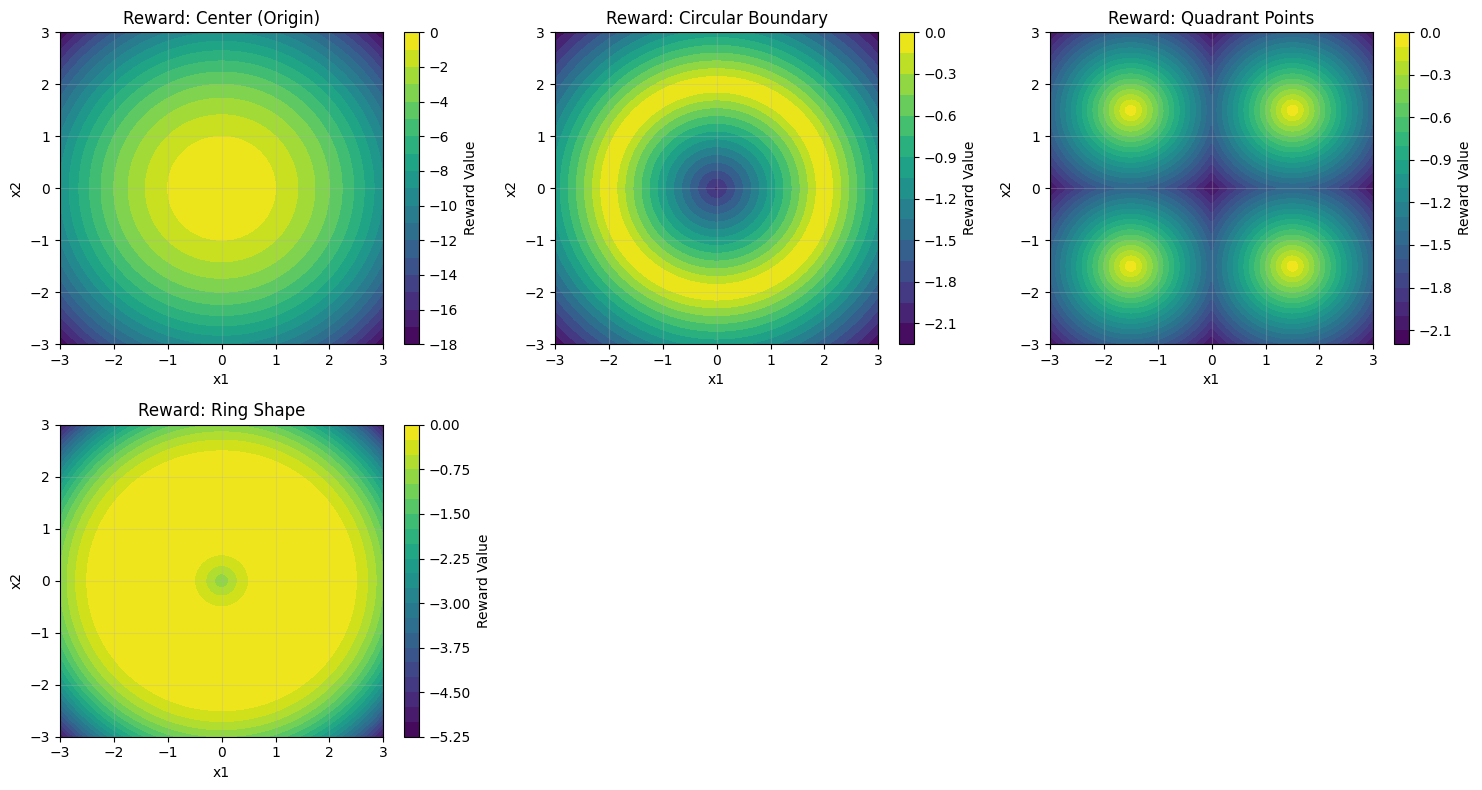


 Generating with reward function: Center (Origin)


reward-tilted generation (Center (Origin)): 100%|██████████| 1000/1000 [00:23<00:00, 42.46it/s]


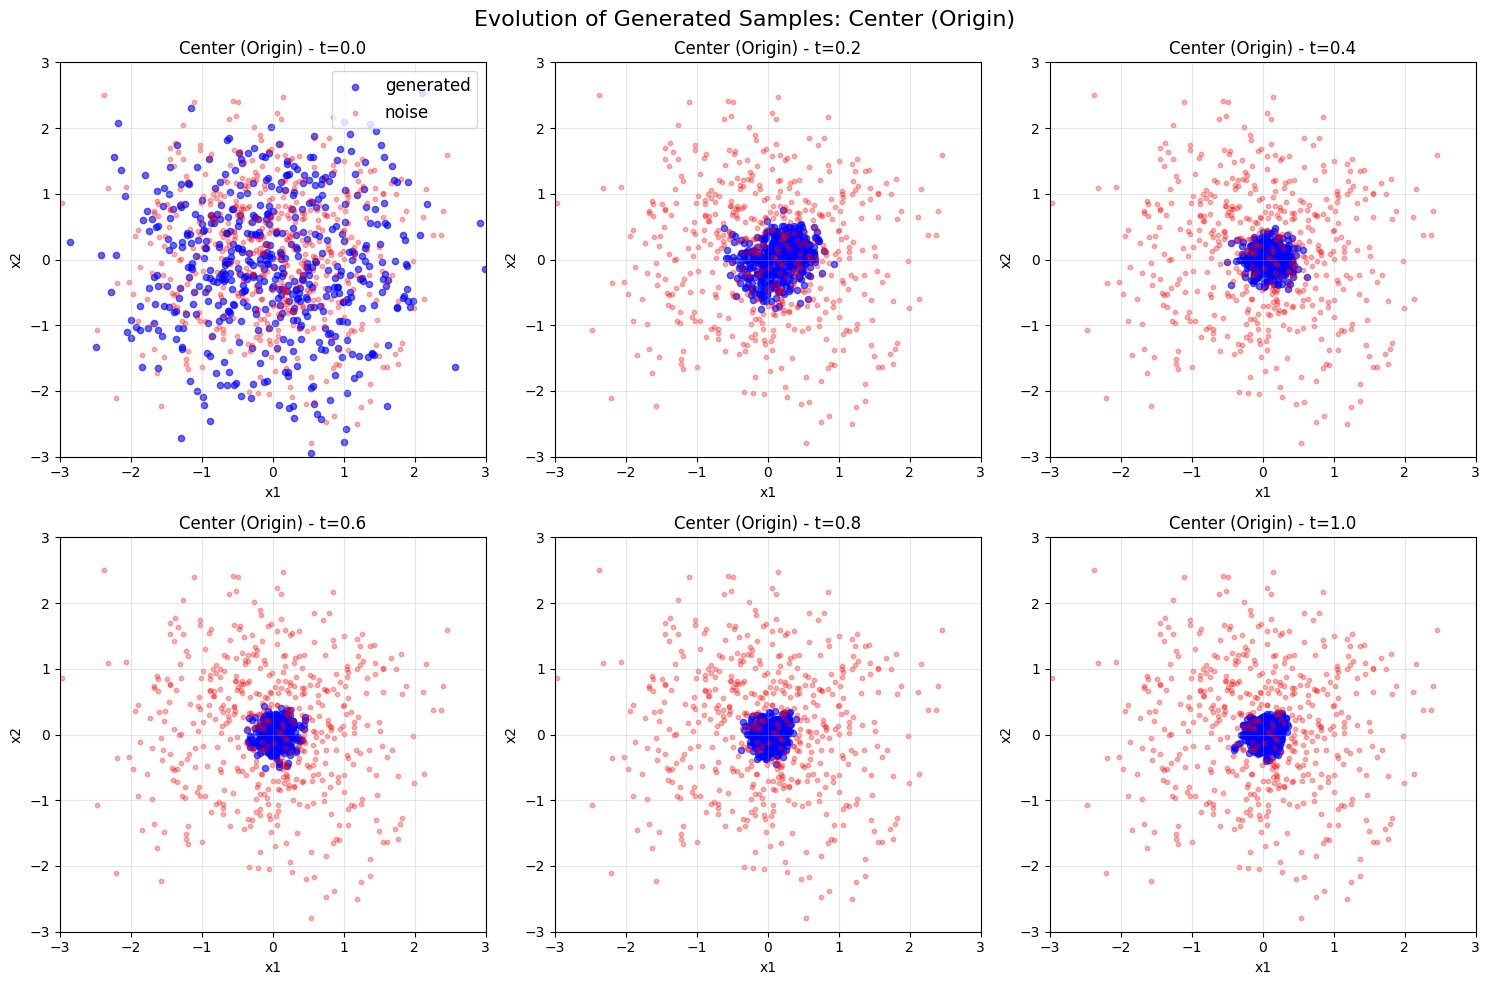

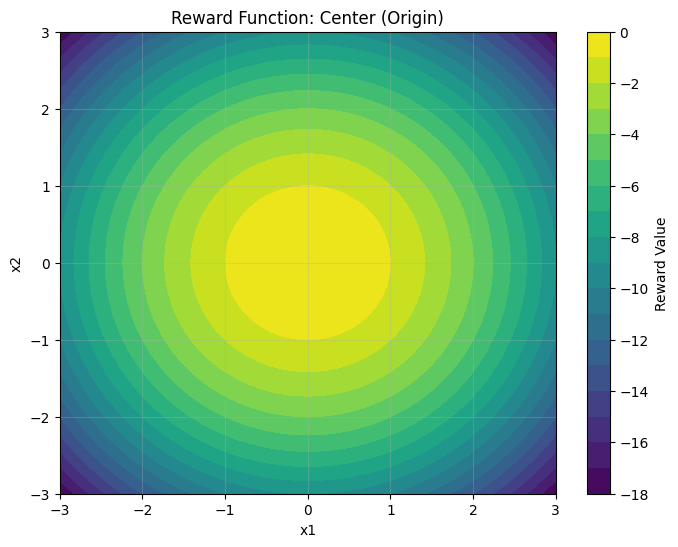


 Generating with reward function: Circular Boundary


reward-tilted generation (Circular Boundary): 100%|██████████| 1000/1000 [00:25<00:00, 38.61it/s]


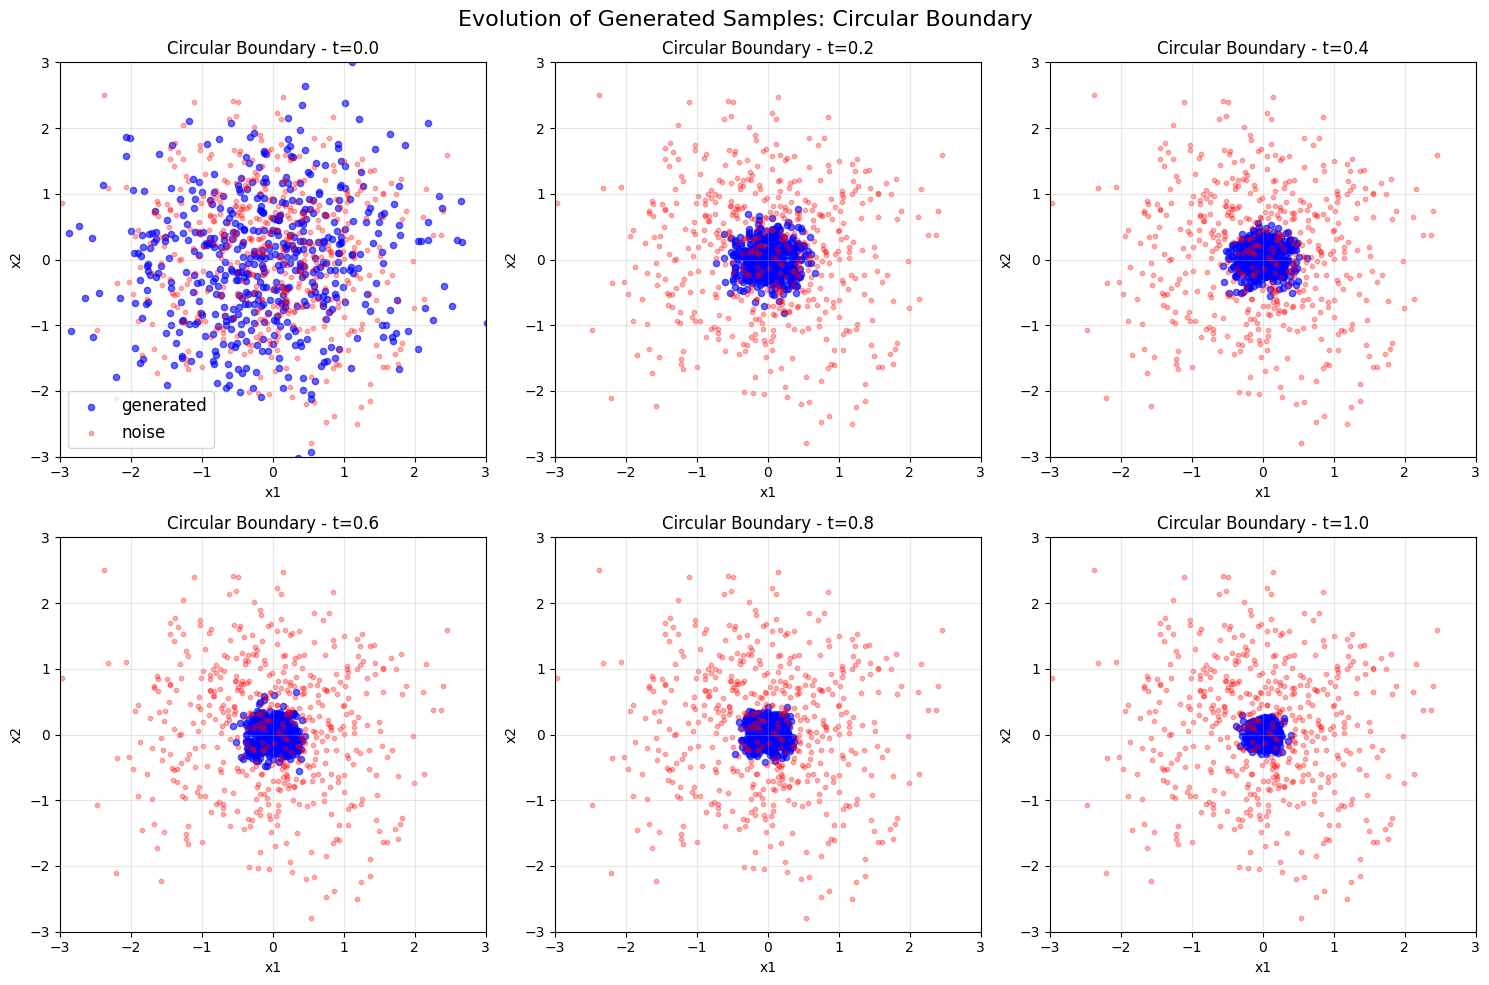

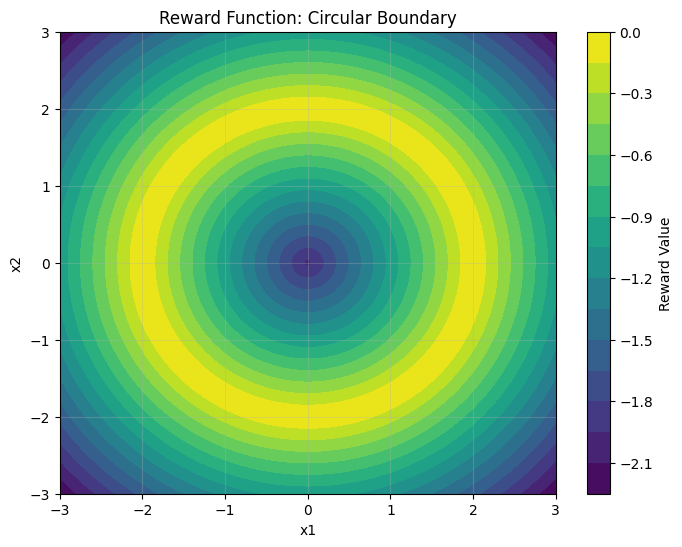


 Generating with reward function: Quadrant Points


reward-tilted generation (Quadrant Points): 100%|██████████| 1000/1000 [00:25<00:00, 38.53it/s]


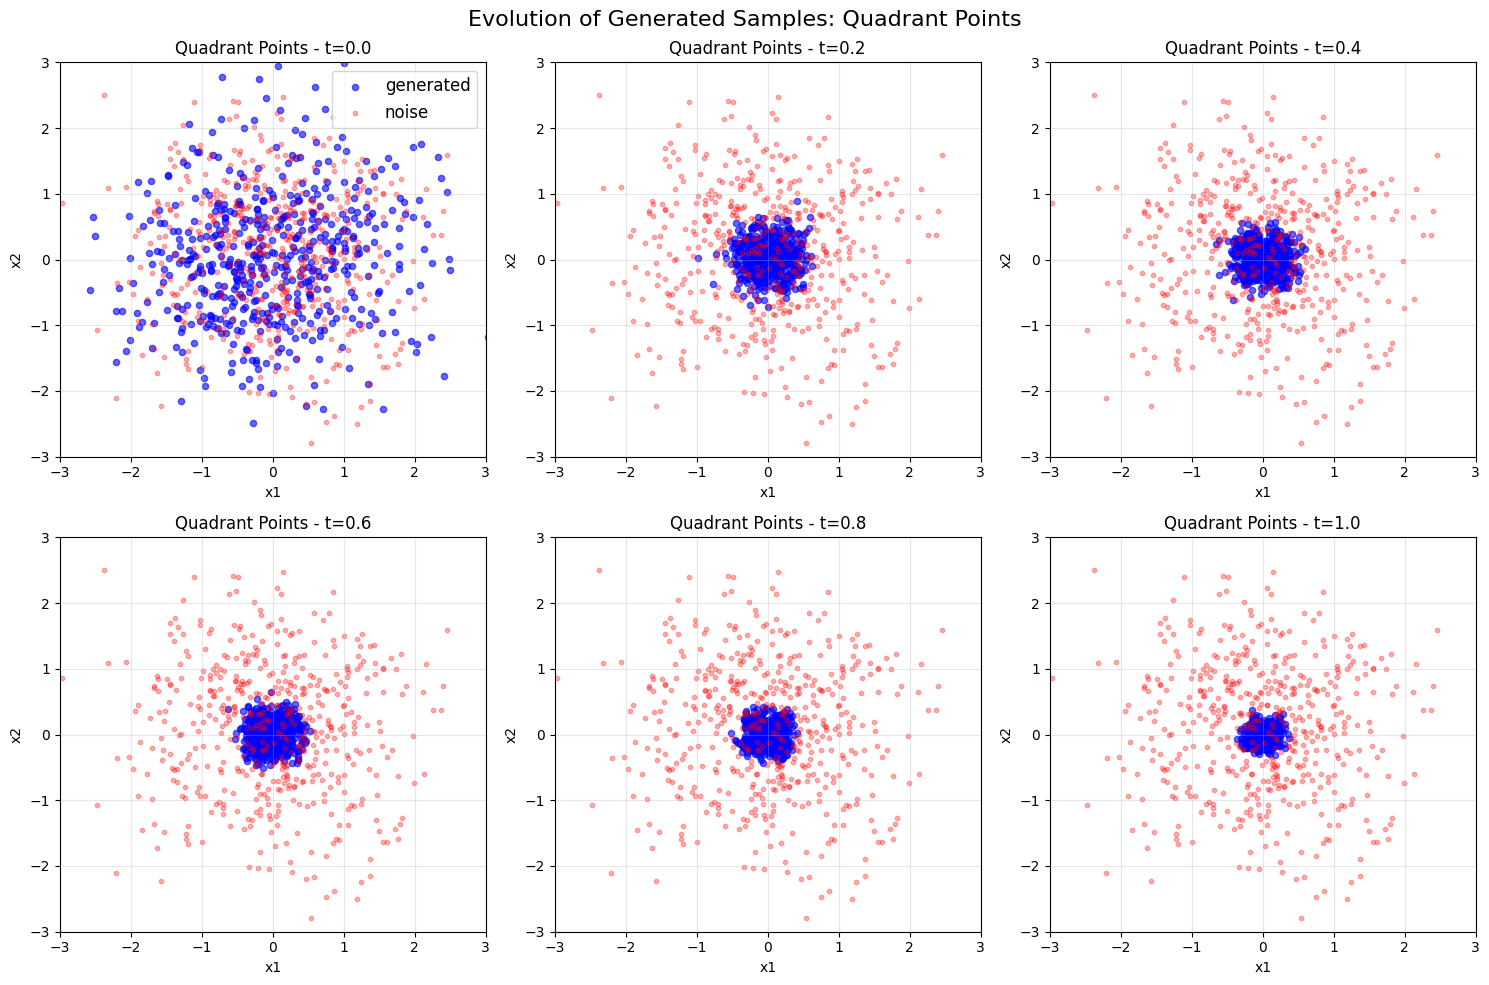

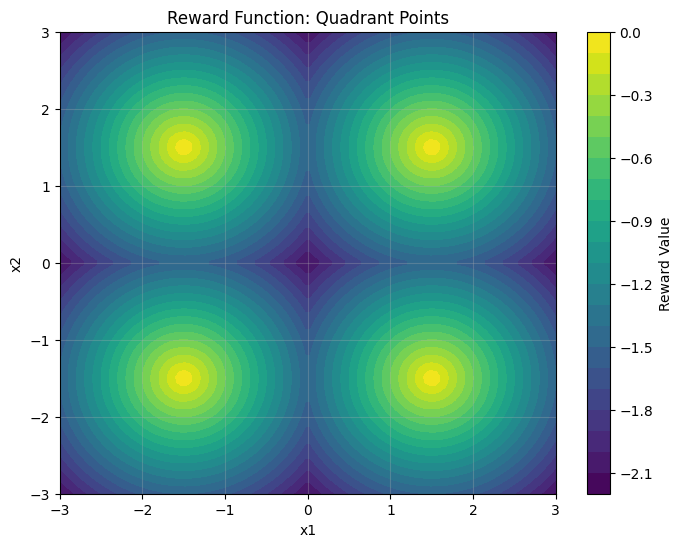


 Generating with reward function: Ring Shape


reward-tilted generation (Ring Shape): 100%|██████████| 1000/1000 [00:32<00:00, 31.12it/s]


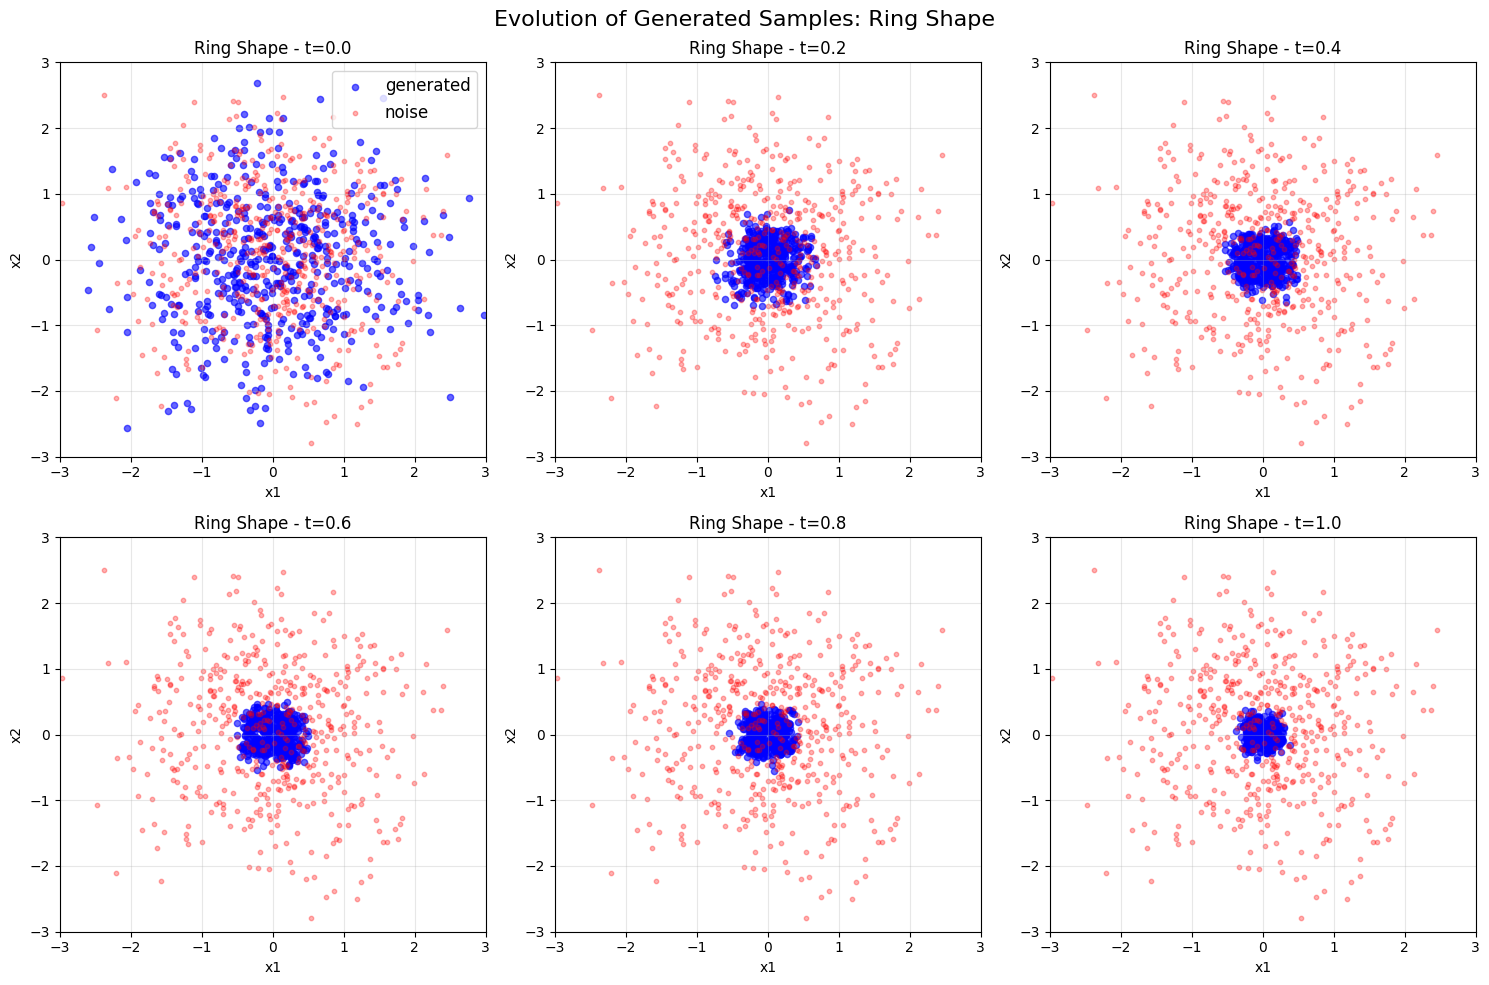

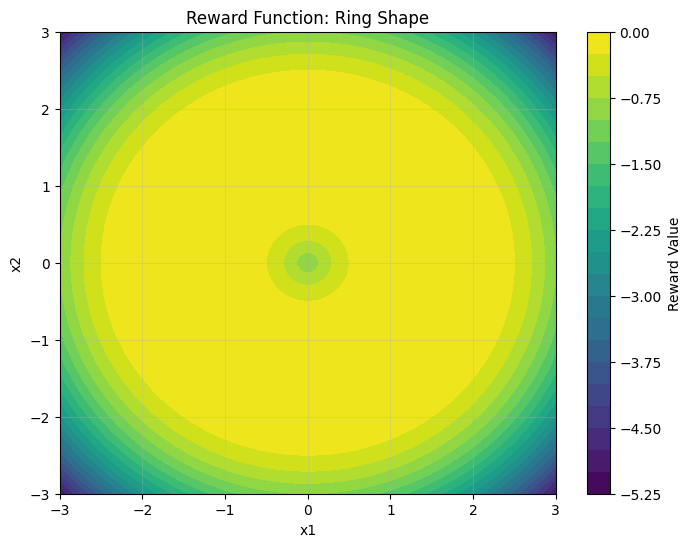

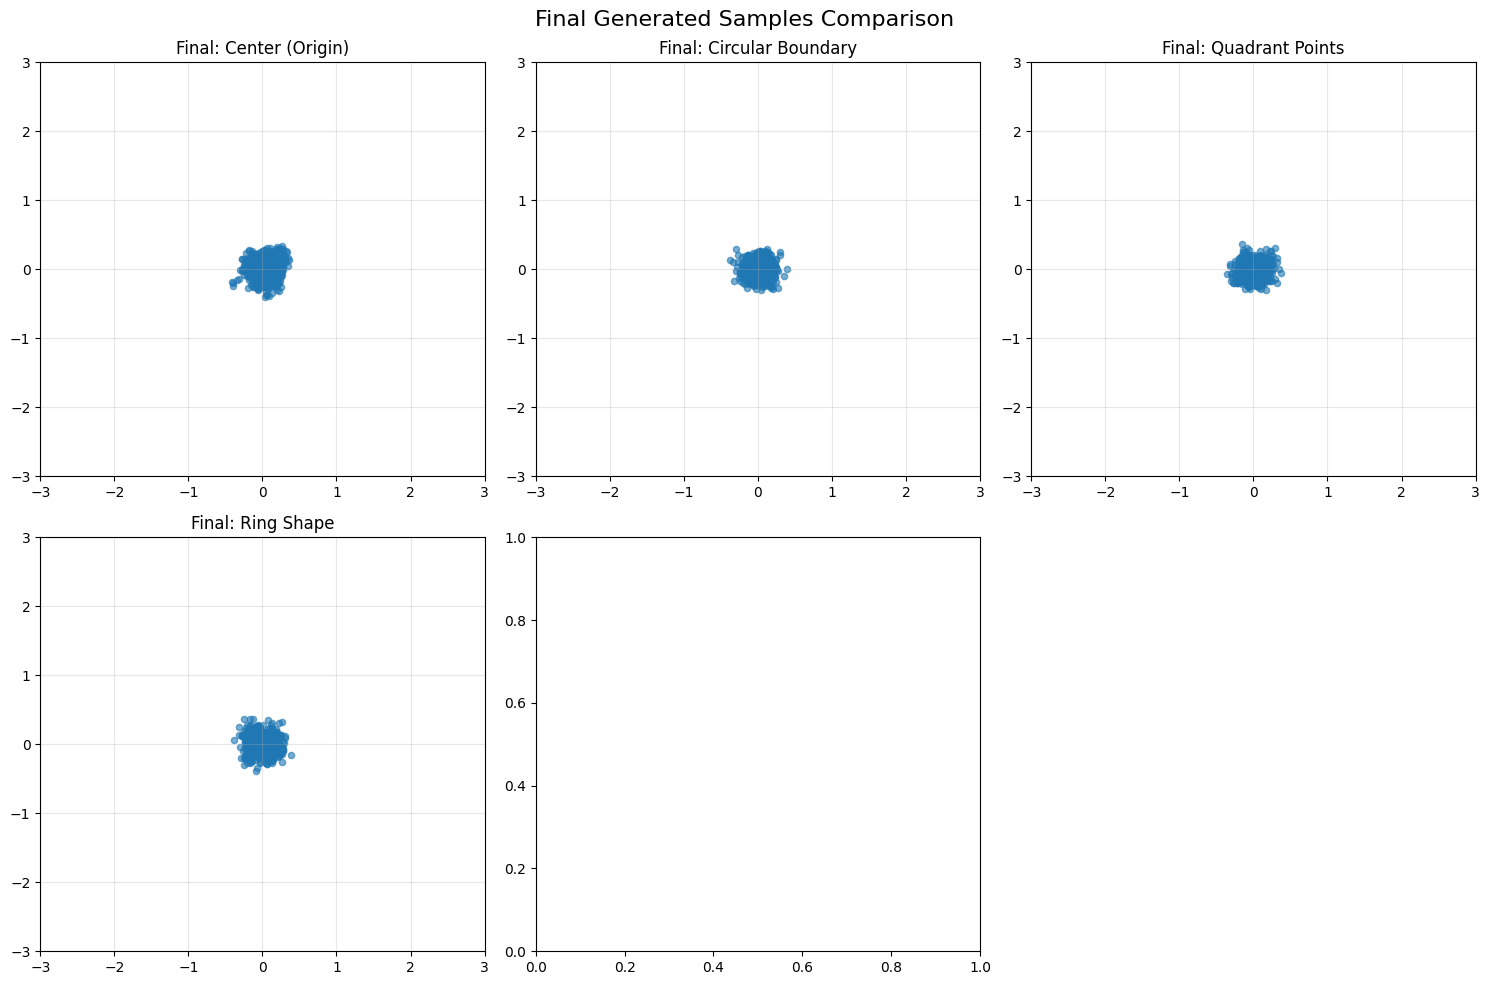

In [34]:
# ===================================================================================
# Main Execution
# ===================================================================================

# Define reward functions and their names
reward_functions = [
    reward_function_center,
    reward_function_boundary,
    reward_function_quadrants,
    reward_function_ring,
]

reward_names = [
    "Center (Origin)",
    "Circular Boundary", 
    "Quadrant Points",
    "Ring Shape",
]

# Create gradient functions
grad_functions = [
    vmap_grad_reward_center,
    vmap_grad_reward_boundary,
    vmap_grad_reward_quadrants,
    vmap_grad_reward_ring,
]

# 1. Visualize all reward functions
plot_reward_comparison(reward_functions, reward_names)

# 2. Generate samples for each reward function
results = {}

# Initialize key
key = random.PRNGKey(42)  # Fixed seed for reproducibility

for reward_func, reward_name, grad_func in zip(reward_functions, reward_names, grad_functions):
    # Generate samples
    key, x_gen, w_gen = generate_with_reward_function(
        key, reward_name, reward_func, grad_func,
        n_steps=1000, bs=512, dt=1e-3, T_max=1.0,
        beta_start=0.1, beta_end=10.0, resample=True
    )
    
    # Store results
    results[reward_name] = {
        'x_gen': x_gen,
        'w_gen': w_gen,
        'final_samples': x_gen[:, -1, :]  # Final generated samples
    }
    
    # Plot evolution following notebook schema
    plot_reward_evolution(reward_name, x_gen, w_gen, n_steps=1000, bs=512)
    
    # Plot reward function heatmap
    plot_reward_heatmap(reward_func, reward_name)

# 3. Compare final distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, (reward_name, data) in enumerate(results.items()):
    ax = axes[i]
    final_samples = data['final_samples']
    
    ax.scatter(final_samples[:, 0], final_samples[:, 1], alpha=0.6, s=20)
    ax.set_title(f'Final: {reward_name}')
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.grid(True, alpha=0.3)

# Hide the last subplot if we have an odd number
if len(reward_functions) < len(axes):
    axes[-1].set_visible(False)

plt.suptitle('Final Generated Samples Comparison', fontsize=16)
plt.tight_layout()
plt.show()

## Generation / Visualization

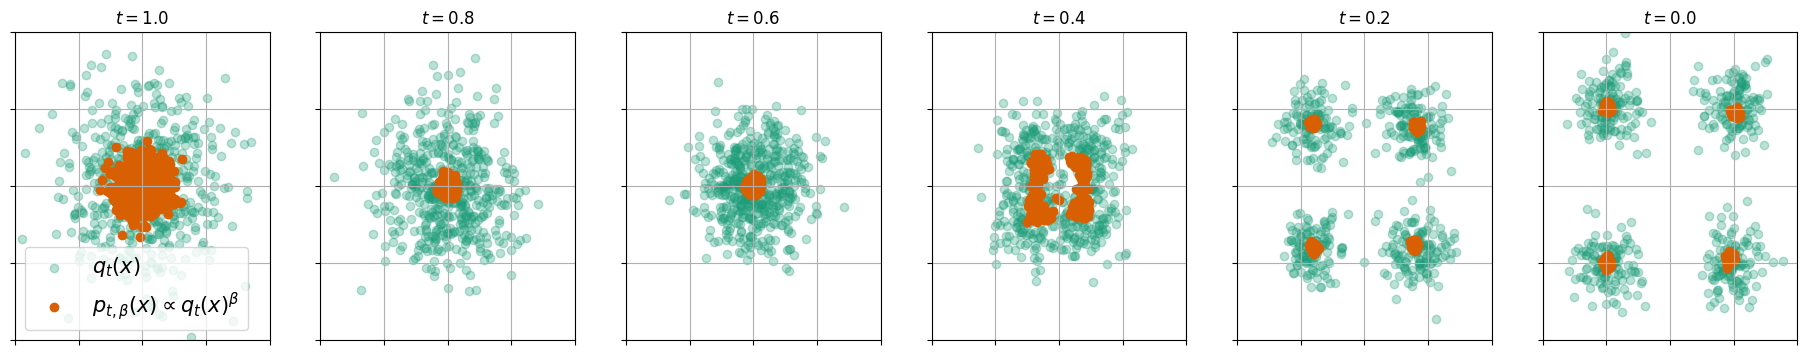

In [15]:
C1="#1D9D79"
C2="#756FB3"
C3="#D96002"

t_axis = np.linspace(0.0, 1.0, 6)
# t_axis = np.linspace(1e-2, 1.0, 6)

plt.figure(figsize=(23,4))
for i in range(len(t_axis)):
  plt.subplot(1,len(t_axis),i+1)
  key, *ikey = random.split(key, 4)
  t = t_axis[len(t_axis)-1-i]
  _, x_t = q_t(ikey[1], sample_data(ikey[0], bs), t)
  plt.scatter(x_t[:,0], x_t[:,1], label=r'$q_t(x)$', alpha=0.3, c=C1)
  if resample:
    ids = jnp.arange(bs)
  else:
    # ids = jax.random.choice(ikey[2], bs, (bs,), p=nn.softmax(w_gen[:,int(n*(t_axis[i])),0]))
    ids, next_u = sample_cat(bs, next_u, w_gen[:,int(n*(t_axis[i])),0])
  
  plt.scatter(x_gen[ids,int(n*(t_axis[i])),0], x_gen[ids,int(n*(t_axis[i])),1], c=C3, label=r'$p_{t,\beta}(x)\propto q_t(x)^\beta$')
  plt.xticks(np.linspace(-3,3,5),[])
  plt.yticks(np.linspace(-3,3,5),[])
  plt.title(rf'$t={t:1.1f}$')
  plt.xlim(-3,3)
  plt.ylim(-3,3)
  plt.grid()
  if i == 0:
    plt.legend(fontsize=15)
    
plt.savefig('toy_annealing.pdf', bbox_inches='tight')

### Euler/Trapezoid/Full Integration Schemes of weights 
#### can probably ignore:  (I didn't see this helping much with the Clocks integrator)

In [16]:
@jax.jit
def sdlogqdx_fn(t,x):
  return state.apply_fn(state.params, t, x)

resample = True

integration = 'trapezoid' # 'full' 'euler'

scale_noise=  True
next_u = 0.5
dt = 1e-3
t = 1.0
n = int(t/dt)
t = t*jnp.ones((bs,1))
key, ikey = random.split(key, num=2)
x_gen = jnp.zeros((bs,n+1,x_t.shape[1]))
x_gen = x_gen.at[:,0,:].set(random.normal(ikey, shape=(bs, x_t.shape[1]))/jnp.sqrt(inv_temp))
w_gen = jnp.zeros((bs,n+1,1))


if integration != 'euler':
  sdlogqdx = sdlogqdx_fn(t, x_gen[:,0,:])
        
for i in trange(n):
  key, *ikey = random.split(key, num=3)
  
  ''' step x ''' 
  if integration == 'euler':
    sdlogqdx = sdlogqdx_fn(t, x_gen[:,i,:])
  # else:  sdlogqdx is taken from previous iteration's evaluation of (t-dt, x_[t-dt])
  
  if not scale_noise:
    dx = dt*(-dlog_alphadt(t)*x_gen[:,i,:] + 2*inv_temp*gamma(t)*sdlogqdx) + jnp.sqrt(2*gamma(t)*jnp.exp(log_sigma(t))*dt)*random.normal(ikey[0], shape=(bs,2))
  else:
    dx = dt*(-dlog_alphadt(t)*x_gen[:,i,:] + (gamma(t)+inv_temp*gamma(t))*sdlogqdx) + jnp.sqrt(2*gamma(t)/inv_temp*jnp.exp(log_sigma(t))*dt)*random.normal(ikey[0], shape=(bs,2))
  x_gen = x_gen.at[:,i+1,:].set(x_gen[:,i,:] + dx)
  
  ''' calculate weights ''' 
  if integration == 'euler':
    dw = dt*((inv_temp-1)*2*dlog_alphadt(t) + 0.5*(inv_temp-1)*inv_temp*((jnp.sqrt(2*gamma(t)/jnp.exp(log_sigma(t)))*sdlogqdx)**2).sum(1, keepdims=True))
  else:
    if integration == 'trapezoid':
      dw = .5*dt*((inv_temp-1)*2*dlog_alphadt(t) + 0.5*(inv_temp-1)*inv_temp*((jnp.sqrt(2*gamma(t)/jnp.exp(log_sigma(t)))*sdlogqdx)**2).sum(1, keepdims=True))
    if i == n-1:
      # perform euler integration at final step
      dw = dw + .5*dw
    else:
      sdlogqdx = sdlogqdx_fn(t - dt, x_gen[:,i+1,:])
      if integration == 'trapezoid':
        ''' trapezoid = .5 euler dw + .5 next dw =  .5 w(t, x_t) dt +  .5 * w(t-dt, x_{t-dt}) dt'''
        dw += .5*dt*((inv_temp-1)*2*dlog_alphadt(t-dt) + 0.5*(inv_temp-1)*inv_temp*((jnp.sqrt(2*gamma(t-dt)/jnp.exp(log_sigma(t-dt)))*sdlogqdx)**2).sum(1, keepdims=True))
      elif integration == 'full':
        ''' full = w(t-dt, x_{t-dt}) dt '''
        dw = dt*((inv_temp-1)*2*dlog_alphadt(t-dt) + 0.5*(inv_temp-1)*inv_temp*((jnp.sqrt(2*gamma(t-dt)/jnp.exp(log_sigma(t-dt)))*sdlogqdx)**2).sum(1, keepdims=True))
  
  
  ''' increment weights '''      
  w_gen = w_gen.at[:,i+1,:].set(w_gen[:,i,:] + dw)
  
  ''' systematic only '''
  if resample:
    new_ids, _ = sample_cat_sys(bs, ikey[1], w_gen[:,i+1,0])
    x_gen = x_gen.at[:,i+1,:].set(x_gen[new_ids,i+1,:])
    w_gen = w_gen.at[:,i+1,:].set(0)
    
  ''' for full/trapezoid:  copy already-calculated scores @ (t-dt, x_{t-dt}) for next iteration'''  
  if integration !='euler':
    sdlogqdx = sdlogqdx[new_ids]
    
  t += -dt

100%|██████████| 1000/1000 [00:43<00:00, 23.07it/s]


## Alternative scheme

Let's use the following estimator
$$dx_\tau = d\tau\bigg(-f_{1-\tau}(x_\tau) + \frac{\beta+1}{2} g_{1-\tau}^2\nabla\log q_{1-\tau}(x_\tau)\bigg) + \frac{g_{1-\tau}}{\sqrt{\beta}}d\bar{W}_\tau\,,$$
$$dw_\tau = (\beta-1)\langle \nabla, f_{1-\tau}\rangle + \frac{1}{2}g_{1-\tau}^2(\beta-1)\beta\Vert\nabla \log q_{1-\tau}\Vert^2$$
where $\beta$ is the inverse temperature

In [17]:
@jax.jit
def sdlogqdx_fn(t,x):
  return state.apply_fn(state.params, t, x)

resample = True
inv_temp = 3
next_u = 0.5
dt = 1e-3
t = 1.0
n = int(t/dt)
t = t*jnp.ones((bs,1))
key, ikey = random.split(key, num=2)
x_gen = jnp.zeros((bs,n+1,x_t.shape[1]))
x_gen = x_gen.at[:,0,:].set(random.normal(ikey, shape=(bs, x_t.shape[1]))/jnp.sqrt(inv_temp))
w_gen = jnp.zeros((bs,n+1,1))
for i in trange(n):
  key, *ikey = random.split(key, num=3)
  sdlogqdx = sdlogqdx_fn(t, x_gen[:,i,:])
  dx = dt*(-dlog_alphadt(t)*x_gen[:,i,:] + 2*(inv_temp+1)/2*gamma(t)*sdlogqdx) + jnp.sqrt(2*gamma(t)*jnp.exp(log_sigma(t))*dt/inv_temp)*random.normal(ikey[0], shape=(bs,2))
  x_gen = x_gen.at[:,i+1,:].set(x_gen[:,i,:] + dx)
  dw = dt*((inv_temp-1)*2*dlog_alphadt(t) + 0.5*(inv_temp-1)*inv_temp*((jnp.sqrt(2*gamma(t)/jnp.exp(log_sigma(t)))*sdlogqdx)**2).sum(1, keepdims=True))
  w_gen = w_gen.at[:,i+1,:].set(w_gen[:,i,:] + dw)
  if resample:
    # new_ids = jax.random.choice(ikey[1], bs, (bs,), p=nn.softmax(w_gen[:,i+1,0]))
    # new_ids, next_u = sample_cat(bs, next_u, w_gen[:,i+1,0])
    new_ids, _ = sample_cat_sys(bs, ikey[1], w_gen[:,i+1,0])
    x_gen = x_gen.at[:,i+1,:].set(x_gen[new_ids,i+1,:])
    w_gen = w_gen.at[:,i+1,:].set(0)
  t += -dt

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:22<00:00, 44.36it/s]


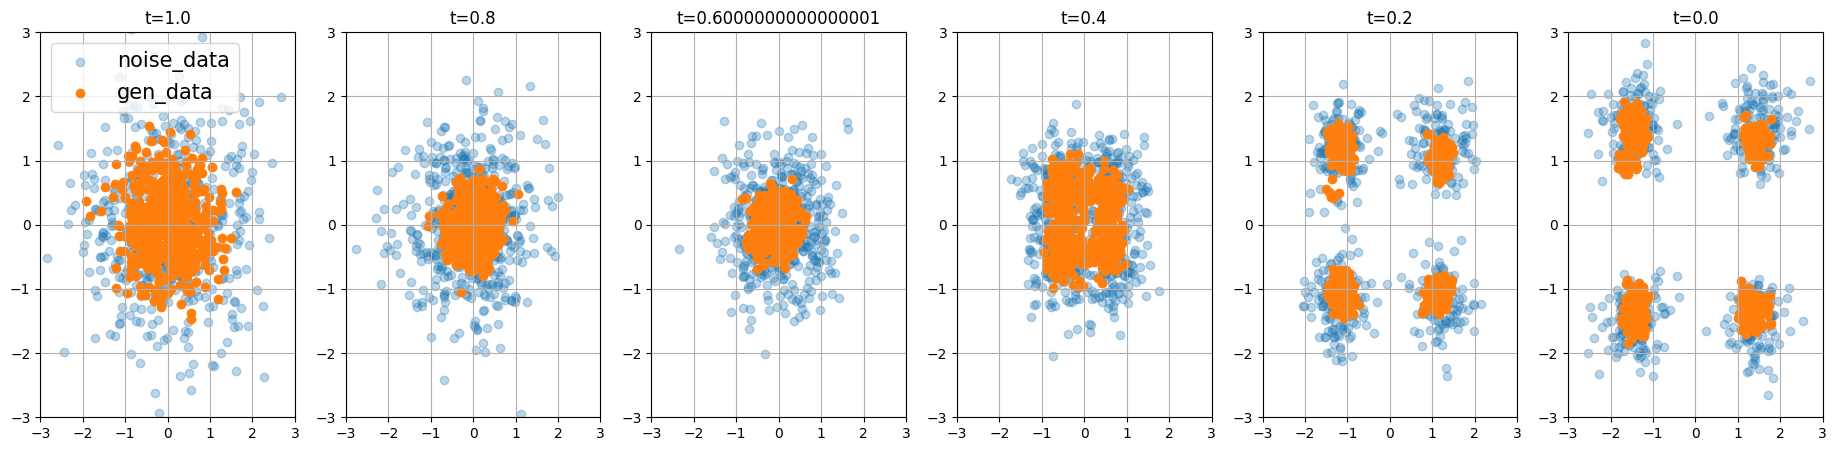

In [18]:
t_axis = np.linspace(0.0, 1.0, 6)
# t_axis = np.linspace(1e-2, 1.0, 6)

plt.figure(figsize=(23,5))
for i in range(len(t_axis)):
  plt.subplot(1,len(t_axis),i+1)
  key, *ikey = random.split(key, 4)
  t = t_axis[len(t_axis)-1-i]
  _, x_t = q_t(ikey[1], sample_data(ikey[0], bs), t)
  plt.scatter(x_t[:,0], x_t[:,1], label='noise_data', alpha=0.3)
  if resample:
    ids = jnp.arange(bs)
  else:
    # ids = jax.random.choice(ikey[2], bs, (bs,), p=nn.softmax(w_gen[:,int(n*(t_axis[i])),0]))
    ids, next_u = sample_cat(bs, next_u, w_gen[:,int(n*(t_axis[i])),0])
  plt.scatter(x_gen[ids,int(n*(t_axis[i])),0], x_gen[ids,int(n*(t_axis[i])),1], label='gen_data')
  plt.title(f't={t}')
  plt.xlim(-3,3)
  plt.ylim(-3,3)
  plt.grid()
  if i == 0:
    plt.legend(fontsize=15)